In [ ]:
import zipfile
with zipfile.ZipFile('drive/MyDrive/MediaEval21/test.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
import os
import glob
import shutil

fols = glob.glob('data/drive/MyDrive/MediaEval21/dataset/*')
for folder in fols:
  shutil.move(folder, 'data/')

In [ ]:
pathAudio={}

with open('train_balance3.tsv') as ftrain:
    contents= ftrain.read().splitlines()
    for con in contents[1:]:
        con=con.split("\t")[3].split(".")[0].split("/")
        #print(con)
        pathAudio[int(con[1])]=con[0]
with open('drive/MyDrive/MediaEval2020/Emotions/mel_spectrogram/moodtheme_mel/autotagging_moodtheme-validation.tsv') as fvalidation:
    contents= fvalidation.read().splitlines()
    for con in contents[1:]:
        con=con.split("\t")[3].split(".")[0].split("/")
        pathAudio[int(con[1])]=con[0]
with open('drive/MyDrive/MediaEval2020/Emotions/mel_spectrogram/moodtheme_mel/autotagging_moodtheme-test.tsv') as ftest:
    contents= ftest.read().splitlines()
    for con in contents[1:]:
        con=con.split("\t")[3].split(".")[0].split("/")
        pathAudio[int(con[1])]=con[0]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable

USE_CUDA = True if torch.cuda.is_available() else False

import numpy as np
import pandas as pd

In [ ]:
torch.set_num_threads(7)
torch.manual_seed(1234)

In [ ]:
import glob
listdata=glob.glob("data/*/*[0-9].npy")
dsample=set([int(i.replace("data/","").replace(".npy","")[3:]) for i in listdata])
#listwav=glob.glob('wavenet/*.npy')
#wsample=set([int(i.replace('wavenet/','').replace('.npy','')) for i in listwav])
print(len(dsample))
#print(len(wsample))

4231


In [ ]:
val_list = list(map(lambda x : x[0], valid_df.iterrows()))
import os 
import zipfile 

zf = zipfile.ZipFile("drive/MyDrive/MediaEval21/val.zip", "w") 
for dirname, subdirs, files in os.walk("drive/MyDrive/MediaEval21/dataset"): 
  for filename in files: 
    name = filename[:-4] 
    path = '0' * (7 - len(name)) + name
    if path in val_list:
      zf.write(os.path.join(dirname, filename)) 
zf.close()

In [ ]:
#file_common = wsample.intersection(dsample)

In [ ]:
import commons
train_info = commons.read_file('train_balance3.tsv')
validation_info = commons.read_file('drive/MyDrive/MediaEval2020/Emotions/mel_spectrogram/moodtheme_mel/autotagging_moodtheme-validation.tsv')
test_info = commons.read_file('drive/MyDrive/MediaEval2020/Emotions/mel_spectrogram/moodtheme_mel/autotagging_moodtheme-test.tsv')

Reading: 9080 tracks, 2376 albums, 841 artists
Reading: 3802 tracks, 927 albums, 307 artists
Reading: 4231 tracks, 1025 albums, 327 artists


In [ ]:
def parse(a_info):
    ans = []
    total = 0
    
    #print(a_info[])
    
    for k,v in a_info[1]['mood/theme'].items():
        
        total += len(list(v))
        
        ans.append(pd.DataFrame({
            k: 1,
            'file': list(v)
        }))
        
    df = ans[0]
    
    
    for x in ans[1:]:
        df = pd.merge(df, x, on='file', how='outer')
    df = df.set_index('file').fillna(0)
    df.loc[:, :] = df.loc[:, :].astype('int64')
    return df

In [ ]:
train_df = parse(train_info)
valid_df = parse(validation_info)
test_df = parse(test_info)

In [ ]:
train_df = train_df.loc[:, sorted(train_df.columns.tolist())]
valid_df = valid_df.loc[:, sorted(valid_df.columns.tolist())]
test_df = test_df.loc[:, sorted(test_df.columns.tolist())]

test_df = test_df.sort_index()

In [ ]:
import random

In [ ]:
def random_30s(name):
    mel = np.load('data/'+str(pathAudio[name])+'/'+str(name)+'.npy')
    mel_len = mel.shape[1]
    offset = random.randint(0, (mel_len - 960))
    cut_mel = mel[:, offset:(offset + 960)]
    # try:
    #     wave = np.load('wavenet/'+str(name)+'.npy')
    # except:
    #     name = (7 - len(str(name))) * "0" + str(name)
    #     wave = np.load('wavenet/'+str(name)+'.npy')
    # wave_len = wave.shape[1]
    # offs = random.randint(0, (wave_len - 600))
    # cut_wave = wave[:, offs: (offs + 600)]
    return cut_mel

In [ ]:
from transforms import get_transforms

In [ ]:
train_transform = get_transforms(
    train=True,
    size=640,
    wrap_pad_prob=0.5,
    resize_scale=(0.8, 1.0),
    resize_ratio=(1.7, 2.3),
    resize_prob=0.33,
    spec_num_mask=3,
    spec_freq_masking=0.15,
    spec_time_masking=0.20,
    spec_prob=0.5
)
val_transform = get_transforms(False, 640)

In [ ]:
train_transform_wave = get_transforms(
    train=True,
    size=960,
    wrap_pad_prob=0.5,
    resize_scale=(0.8, 1.0),
    resize_ratio=(1.7, 2.3),
    resize_prob=0.33,
    spec_num_mask=1,
    spec_freq_masking=0.1,
    spec_time_masking=0.15,
    spec_prob=0.7
)
val_transform_wave = get_transforms(False, 960)

In [ ]:
class AudioDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        
        this_file = self.df.index[idx]
        name = int(this_file)
        
        #mel = random_30s(name)
        # try:
        #     sample = np.load('wavenet/'+str(name)+'.npy')
        # except:
        #     name = (7 - len(str(name))) * "0" + str(name)
        #     sample = np.load('wavenet/'+str(name)+'.npy')

        image = np.load('data/'+str(pathAudio[name])+'/'+str(name)+'.npy')
        # image = np.transpose(image, (0,2,1))        
        # image = np.squeeze(image)        
        
        #image = np.tile(image, (2,1))
        #print(image.shape)

        #print("Image", image.shape)

        if self.transform is not None:
            image = self.transform(image)

        # wave = np.transpose(wave, (0,2,1))        
        # wave = np.squeeze(wave)        
        # wave = np.tile(wave, (2,1))
             
        # if self.transform is not None:
        #     mel = self.transform(mel)
            #wave = self.transform[1](wave)
        
        return image, torch.Tensor(self.df.values[idx])

In [ ]:
train_dataset = AudioDataset(train_df, train_transform)
valid_dataset = AudioDataset(valid_df, val_transform)
test_dataset = AudioDataset(test_df, val_transform)

In [ ]:
print(len(test_dataset))

4231


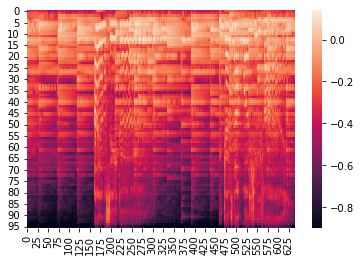

In [ ]:
import seaborn as sns
sns.heatmap(test_dataset[10][0][0, :, :].numpy())

In [ ]:
!pip install timm

     |████████████████████████████████| 376 kB 7.6 MB/s 


In [ ]:
import timm

In [ ]:
class Model_Rex(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.batch_normal = nn.BatchNorm2d(1)
        self.bw2col = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 10, 1, padding=0), nn.ReLU(),
            nn.Conv2d(10, 3, 1, padding=0), nn.ReLU())
      
        self.mv2 = timm.create_model('rexnet_100', pretrained=True, num_classes=56)
    
    def forward(self, x):
        x = self.batch_normal(x)
        x = self.bw2col(x)
        x = self.mv2(x)
        return x

In [ ]:
class Model_Reg(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.batch_normal = nn.BatchNorm2d(1)
        self.bw2col = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 10, 1, padding=0), nn.ReLU(),
            nn.Conv2d(10, 3, 1, padding=0), nn.ReLU())
      
        self.mv2 = timm.create_model('mixnet_s', pretrained=True, num_classes=56)
    
    def forward(self, x):
        x = self.batch_normal(x)
        x = self.bw2col(x)
        x = self.mv2(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)

Device:  cuda


In [ ]:
from hparams import create_hparams
model_rex = Model_Rex().to(device)
model_reg = Model_Reg().to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rexnet/rexnetv1_100-1b4dddf4.pth" to /root/.cache/torch/hub/checkpoints/rexnetv1_100-1b4dddf4.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mixnet_s-a907afbc.pth" to /root/.cache/torch/hub/checkpoints/mixnet_s-a907afbc.pth


In [ ]:
optimizer_rex = optim.Adam(model_rex.parameters(), lr=0.001, amsgrad=True)
scheduler_rex = optim.lr_scheduler.ReduceLROnPlateau(optimizer_rex, patience=5, verbose=True)
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001, amsgrad=True)
scheduler_reg = optim.lr_scheduler.ReduceLROnPlateau(optimizer_reg, patience=5, verbose=True)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        
        pt = torch.exp(-BCE_loss)

        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [ ]:
class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha])
        if torch.cuda.is_available():
          self.alpha = self.alpha.cuda()
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        #targets = targets.type(torch.long)
        
        
        #print(targets)
        
        y = torch.ones(targets.shape)
        if torch.cuda.is_available():
          y = y.cuda()
        targets = torch.where(targets == 0, targets, y)
        
        targets = targets.type(torch.long)
        
        #print(targets)
        
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        
        
        #print(targets)
        #print(at)
        at = at.view(-1, 56)
        #print(at)
        
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss

In [ ]:
#criterion = nn.BCEWithLogitsLoss(reduction='none')
#criterion = FocalLoss(gamma=2,logits=True,reduce=False)
criterion = WeightedFocalLoss(gamma=2)

In [ ]:
val_loader = DataLoader(valid_dataset, 256, shuffle=False)
train_loader_1 = DataLoader(train_dataset, 32, shuffle=True, drop_last=True)
train_loader_2 = DataLoader(train_dataset, 32, shuffle=True, drop_last=True)

In [ ]:
epochs = 200

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [ ]:
import tqdm

In [ ]:
def get_tensor(fn):
    # load audio
    name = int(fn)

    x = torch.zeros(16, 1, 96, 640)
    #y = torch.zeros(16, 1, 32, 400)

    mel = np.load('data/'+str(pathAudio[name])+'/'+str(name)+'.npy')
    mel_len = mel.shape[1]

    chunk = (mel_len - 960) // 16

    for i in range(16):
      offset = i * chunk
      cut_mel = mel[:, offset:(offset + 960)]
      x[i] = val_transform(cut_mel)
      # wave = np.transpose(wave, (0,2,1))        
      # wave = np.squeeze(wave)        
      # wave = np.tile(wave, (2,1))
      # y[i] = val_transform_wave(wave)
    return x

In [ ]:
def coteaching_loss(y_1, y_2, t, forget_rate):
    loss_1 = criterion(y_1, t).mean(dim=1)
    ind_1_sorted = torch.argsort(loss_1.data).to(device)

    loss_2 = criterion(y_2, t).mean(dim=1)
    ind_2_sorted = torch.argsort(loss_2.data).to(device)

    remember_rate = 1 - forget_rate
    num_remember = int(remember_rate * len(ind_1_sorted))

    ind_1_update=ind_1_sorted[:num_remember]
    ind_2_update=ind_2_sorted[:num_remember]

    loss_1_update = criterion(y_1[ind_2_update], t[ind_2_update]).mean(dim=0).mean(dim=0)
    loss_2_update = criterion(y_2[ind_1_update], t[ind_1_update]).mean(dim=0).mean(dim=0)

    return loss_1_update, loss_2_update

In [ ]:
train_loss_hist = []
train_loss_hist_each_class = []

valid_loss_hist = []
valid_loss_hist_each_class = []

best_rex, best_mix = 0, 0
#best = 0
epochs_without_new_lowest = 0
#lowest_val_loss_each_class = np.array([float('inf') for _ in range(56)])

#model_rex.load_state_dict(torch.load('drive/MyDrive/MediaEval21/Emotion/model_coteaching_rex_'))
#model_reg.load_state_dict(torch.load('drive/MyDrive/MediaEval21/Emotion/model_coteaching_mixs_'))

for i in range(epochs):
    print('Epoch: ', i)
    
    this_epoch_train_loss = 0
    this_epoch_train_loss_each_class = np.zeros(56)
    
    for i1, i2 in zip(train_loader_1, train_loader_2):
        # mixup---------
        alpha = 1
        mixup_vals = np.random.beta(alpha, alpha, i1[0].shape[0])
        
        lam = torch.Tensor(mixup_vals.reshape(mixup_vals.shape[0], 1, 1, 1))
        mels = (lam * i1[0]) + ((1 - lam) * i2[0])
        #wavs = (lam * i1[1]) + ((1 - lam) * i2[1])
        lam = torch.Tensor(mixup_vals.reshape(mixup_vals.shape[0], 1))
        labels = (lam * i1[1]) + ((1 - lam) * i2[1])
        # mixup ends ----------
        
        # # https://stackoverflow.com/questions/55563376/pytorch-how-does-pin-memory-works-in-dataloader
        mels = mels.to(device, non_blocking=False)
        #wavs = wavs.to(device, non_blocking=False)
        labels = labels.to(device, non_blocking=False)
        
        #print(inputs.size())
        
        optimizer_rex.zero_grad()
        optimizer_reg.zero_grad()
        with torch.set_grad_enabled(True):
            model_rex = model_rex.train()
            model_reg = model_reg.train()
            logits_rex = model_rex(mels)
            logits_reg = model_reg(mels)

            loss_rex, loss_reg = coteaching_loss(logits_rex, logits_reg, labels, 0.05)
            
            loss_rex.backward()
            optimizer_rex.step()
            loss_reg.backward()
            optimizer_reg.step()
            
            loss_val = loss_rex.detach().cpu().numpy() + loss_reg.detach().cpu().numpy()
            
            this_epoch_train_loss += loss_val
    
    this_epoch_valid_loss = 0
    this_epoch_valid_rex = 0
    this_epoch_valid_reg = 0
    
    all_rexs = []
    all_regs = []
    all_labs = []
    for fn, row in tqdm.tqdm(valid_df.iterrows(), total=valid_df.shape[0]):
        mel = get_tensor(fn)
        ground_truth = row.values
        
        mel = mel.to(device)
        #wav = wav.to(device)
        optimizer_rex.zero_grad()
        optimizer_reg.zero_grad()
        with torch.set_grad_enabled(False):
            model_rex = model_rex.eval()
            model_reg = model_reg.eval()
            logits_rex = model_rex(mel)
            logits_reg = model_reg(mel)
            
            out_rex = logits_rex.detach().cpu()
            out_reg = logits_reg.detach().cpu()
            est_rex = np.array(out_rex).mean(axis=0)
            est_reg = np.array(out_reg).mean(axis=0)

            avg_rex = torch.mean(logits_rex, dim=0).unsqueeze(0)
            avg_reg = torch.mean(logits_reg, dim=0).unsqueeze(0)
            loss_rex = criterion(avg_rex, torch.tensor([ground_truth]).type(torch.cuda.FloatTensor))
            loss_reg = criterion(avg_reg, torch.tensor([ground_truth]).type(torch.cuda.FloatTensor))

            loss_rex = loss_rex.mean(dim=0).mean(dim=0).detach().cpu().numpy()
            loss_reg = loss_reg.mean(dim=0).mean(dim=0).detach().cpu().numpy()
            
            this_epoch_valid_loss += loss_rex + loss_reg
            this_epoch_valid_rex += loss_rex
            this_epoch_valid_reg += loss_reg
            all_rexs.append(est_rex)
            all_regs.append(est_reg)
            all_labs.append(ground_truth)
    # for inputs, labels in val_loader:
        
    #     inputs = inputs.to(device)
    #     labels = labels.to(device)
        
    #     optimizer_rex.zero_grad()
    #     optimizer_reg.zero_grad()
    #     with torch.set_grad_enabled(False):
    #         model_rex = model_rex.eval()
    #         model_reg = model_reg.eval()
    #         logits_rex = model_rex(inputs)
    #         logits_reg = model_reg(inputs)
            
    #         loss_rex = criterion(logits_rex, labels)
    #         loss_reg = criterion(logits_reg, labels)
            
    #         loss_val = loss_rex.mean(dim=0).mean(dim=0).detach().cpu().numpy() + loss_reg.mean(dim=0).mean(dim=0).detach().cpu().numpy()
            
    #         this_epoch_valid_loss += loss_val
    #         all_rexs.append(logits_rex.detach().cpu().numpy())
    #         all_regs.append(logits_reg.detach().cpu().numpy())
    #         all_labs.append(labels.detach().cpu().numpy())

    
    this_epoch_train_loss /= len(train_loader_1)
    
    this_epoch_valid_loss /= len(val_loader)
    
    train_loss_hist.append(this_epoch_train_loss)
    valid_loss_hist.append(this_epoch_valid_loss)

    all_rexs = np.concatenate(all_rexs, axis=0)
    all_rexs = 1 / (1 + np.exp(-all_rexs))

    all_regs = np.concatenate(all_regs, axis=0)
    all_regs = 1 / (1 + np.exp(-all_regs))

    #ensemble = 0.6 * all_rexs + 0.4 * all_regs

    all_labs  = np.concatenate(all_labs,  axis=0)

    pr_auc_rex = average_precision_score(all_labs, all_rexs, average='macro')
    roc_auc_rex = roc_auc_score(all_labs, all_rexs, average='macro')
    pr_auc_reg = average_precision_score(all_labs, all_regs, average='macro')
    roc_auc_reg = roc_auc_score(all_labs, all_regs, average='macro')
    # pr_auc = average_precision_score(all_labs, ensemble, average='macro')
    # roc_auc = roc_auc_score(all_labs, ensemble, average='macro')
    print({'train_loss' : this_epoch_train_loss, 'val_loss' : this_epoch_valid_loss})
    print({'pr_auc_rex': pr_auc_rex, 'roc_auc_rex': roc_auc_rex})
    print({'pr_auc_mix': pr_auc_reg, 'roc_auc_mix': roc_auc_reg})
    if pr_auc_rex > best_rex:
        best_rex = pr_auc_rex
        torch.save(model_rex.state_dict(), 'drive/MyDrive/MediaEval21/Emotion/model_coteaching_rex_ver4')
        epochs_without_new_lowest = 0
        print('Saved rex....')
    if pr_auc_reg > best_mix:
        best_mix = pr_auc_reg
        torch.save(model_reg.state_dict(), 'drive/MyDrive/MediaEval21/Emotion/model_coteaching_mixs_ver4')
        epochs_without_new_lowest = 0
        print('Saved mix....')
    epochs_without_new_lowest += 1
    # if pr_auc > best:
    #     best = pr_auc
    #     torch.save(model_rex.state_dict(), 'drive/MyDrive/MediaEval21/Emotion/model_coteaching_rex_ensemble')
    #     torch.save(model_reg.state_dict(), 'drive/MyDrive/MediaEval21/Emotion/model_coteaching_reg_ensemble')
    #     epochs_without_new_lowest = 0
    #     print('Saved...')
    # else:
    #     epochs_without_new_lowest += 1
    if epochs_without_new_lowest >= 10:
        break
    
    scheduler_rex.step(this_epoch_valid_rex)
    scheduler_reg.step(this_epoch_valid_reg)


Epoch:  0


100%|██████████| 3787/3787 [04:55<00:00, 12.80it/s]


{'train_loss': 0.03633743843578912, 'val_loss': 10.258829113282264}
{'pr_auc_rex': 0.06774647955871507, 'roc_auc_rex': 0.7071497384383094}
{'pr_auc_mix': 0.07643523072061642, 'roc_auc_mix': 0.7236210197789243}
Saved rex....
Saved mix....
Epoch:  1


100%|██████████| 3787/3787 [04:56<00:00, 12.79it/s]


{'train_loss': 0.031795327921549904, 'val_loss': 9.66443083913376}
{'pr_auc_rex': 0.08128000244071584, 'roc_auc_rex': 0.7371217871176294}
{'pr_auc_mix': 0.08834455477331495, 'roc_auc_mix': 0.7448468841964782}
Saved rex....
Saved mix....
Epoch:  2


100%|██████████| 3787/3787 [04:55<00:00, 12.81it/s]


{'train_loss': 0.030910258221023893, 'val_loss': 9.92282726187259}
{'pr_auc_rex': 0.09177593815715757, 'roc_auc_rex': 0.7447865278501493}
{'pr_auc_mix': 0.08435652493707937, 'roc_auc_mix': 0.734315801893137}
Saved rex....
Epoch:  3


100%|██████████| 3787/3787 [04:54<00:00, 12.84it/s]


{'train_loss': 0.030566074865612577, 'val_loss': 9.661495102879902}
{'pr_auc_rex': 0.09783430016751742, 'roc_auc_rex': 0.7571756553056559}
{'pr_auc_mix': 0.09764707175574232, 'roc_auc_mix': 0.7562534917217858}
Saved rex....
Saved mix....
Epoch:  4


100%|██████████| 3787/3787 [04:55<00:00, 12.84it/s]


{'train_loss': 0.030207941797396814, 'val_loss': 9.590162654096881}
{'pr_auc_rex': 0.10539655958465372, 'roc_auc_rex': 0.7665147282006576}
{'pr_auc_mix': 0.10031099948092165, 'roc_auc_mix': 0.7564791415990839}
Saved rex....
Saved mix....
Epoch:  5


100%|██████████| 3787/3787 [04:55<00:00, 12.83it/s]


{'train_loss': 0.029749622178785767, 'val_loss': 9.801946845588585}
{'pr_auc_rex': 0.10453219161643706, 'roc_auc_rex': 0.7599679283481022}
{'pr_auc_mix': 0.10402369516667483, 'roc_auc_mix': 0.7555284256686444}
Saved mix....
Epoch:  6


100%|██████████| 3787/3787 [04:55<00:00, 12.81it/s]


{'train_loss': 0.029675416602152036, 'val_loss': 9.709225061163306}
{'pr_auc_rex': 0.10065124581572028, 'roc_auc_rex': 0.7623231627230516}
{'pr_auc_mix': 0.09525770633295015, 'roc_auc_mix': 0.7577361945155061}
Epoch:  7


100%|██████████| 3787/3787 [04:54<00:00, 12.85it/s]


{'train_loss': 0.029476369030985005, 'val_loss': 9.721480155053237}
{'pr_auc_rex': 0.10442651696427613, 'roc_auc_rex': 0.7625184340516971}
{'pr_auc_mix': 0.10283207505245404, 'roc_auc_mix': 0.7523621815633228}
Epoch     8: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  8


100%|██████████| 3787/3787 [04:51<00:00, 12.97it/s]


{'train_loss': 0.02910410573190831, 'val_loss': 9.634639488191654}
{'pr_auc_rex': 0.09845426601543675, 'roc_auc_rex': 0.7587809712645682}
{'pr_auc_mix': 0.11249953754921675, 'roc_auc_mix': 0.7762763284001097}
Saved mix....
Epoch:  9


100%|██████████| 3787/3787 [04:55<00:00, 12.83it/s]


{'train_loss': 0.028825012735811107, 'val_loss': 9.578710283370068}
{'pr_auc_rex': 0.09943536811331291, 'roc_auc_rex': 0.7657923521304194}
{'pr_auc_mix': 0.11301262742441469, 'roc_auc_mix': 0.7796153228670625}
Saved mix....
Epoch:  10


100%|██████████| 3787/3787 [04:51<00:00, 12.97it/s]


{'train_loss': 0.028738238274099978, 'val_loss': 9.52019392500321}
{'pr_auc_rex': 0.11518374066089748, 'roc_auc_rex': 0.7712765859135579}
{'pr_auc_mix': 0.11439121135642852, 'roc_auc_mix': 0.7776029549353105}
Saved rex....
Saved mix....
Epoch:  11


100%|██████████| 3787/3787 [04:51<00:00, 13.01it/s]


{'train_loss': 0.02862318592634818, 'val_loss': 9.534685112256557}
{'pr_auc_rex': 0.11379100739515366, 'roc_auc_rex': 0.7740924699966196}
{'pr_auc_mix': 0.11494816581618295, 'roc_auc_mix': 0.777760267874207}
Saved mix....
Epoch:  12


100%|██████████| 3787/3787 [04:53<00:00, 12.92it/s]


{'train_loss': 0.028558609742961878, 'val_loss': 9.6613619716838}
{'pr_auc_rex': 0.10187535956706628, 'roc_auc_rex': 0.766423471865217}
{'pr_auc_mix': 0.11540847716234472, 'roc_auc_mix': 0.7788184376744705}
Saved mix....
Epoch:  13


100%|██████████| 3787/3787 [04:53<00:00, 12.92it/s]


{'train_loss': 0.028346256584140427, 'val_loss': 9.58571578587095}
{'pr_auc_rex': 0.10605416534328099, 'roc_auc_rex': 0.7709440972186095}
{'pr_auc_mix': 0.11500201073955407, 'roc_auc_mix': 0.7790403438568396}
Epoch:  14


100%|██████████| 3787/3787 [04:51<00:00, 13.00it/s]


{'train_loss': 0.02817937620776765, 'val_loss': 9.653277966069679}
{'pr_auc_rex': 0.10954833187154842, 'roc_auc_rex': 0.7716104056742481}
{'pr_auc_mix': 0.1136712249836713, 'roc_auc_mix': 0.7781460587699249}
Epoch:  15


100%|██████████| 3787/3787 [04:55<00:00, 12.80it/s]


{'train_loss': 0.028028824762936604, 'val_loss': 9.702273819285134}
{'pr_auc_rex': 0.10385991180859017, 'roc_auc_rex': 0.7641490363914543}
{'pr_auc_mix': 0.11154929246589035, 'roc_auc_mix': 0.7762316848961052}
Epoch:  16


100%|██████████| 3787/3787 [04:56<00:00, 12.79it/s]


{'train_loss': 0.028181678734402707, 'val_loss': 9.633282301559424}
{'pr_auc_rex': 0.10987097528693596, 'roc_auc_rex': 0.7668748721943826}
{'pr_auc_mix': 0.11633340489815869, 'roc_auc_mix': 0.7791610716356829}
Saved mix....
Epoch    17: reducing learning rate of group 0 to 1.0000e-04.
Epoch:  17


100%|██████████| 3787/3787 [04:54<00:00, 12.84it/s]


{'train_loss': 0.027957962700396986, 'val_loss': 9.607287130411715}
{'pr_auc_rex': 0.11764962477558227, 'roc_auc_rex': 0.7786522138287355}
{'pr_auc_mix': 0.11480194493895643, 'roc_auc_mix': 0.7796612274214356}
Saved rex....
Epoch:  18


100%|██████████| 3787/3787 [04:55<00:00, 12.82it/s]


{'train_loss': 0.027740031778019793, 'val_loss': 9.621474395940702}
{'pr_auc_rex': 0.11873349252698122, 'roc_auc_rex': 0.7792619355502671}
{'pr_auc_mix': 0.1179916158680329, 'roc_auc_mix': 0.7797207478383638}
Saved rex....
Saved mix....
Epoch:  19


100%|██████████| 3787/3787 [04:57<00:00, 12.74it/s]


{'train_loss': 0.02773938336614387, 'val_loss': 9.622963587846607}
{'pr_auc_rex': 0.1181628662572902, 'roc_auc_rex': 0.7786087195825977}
{'pr_auc_mix': 0.11649028212928966, 'roc_auc_mix': 0.7776016861484365}
Epoch:  20


100%|██████████| 3787/3787 [04:56<00:00, 12.76it/s]


{'train_loss': 0.027708795780302786, 'val_loss': 9.806436789485936}
{'pr_auc_rex': 0.1149381277452264, 'roc_auc_rex': 0.7749537658511585}
{'pr_auc_mix': 0.1120133529501165, 'roc_auc_mix': 0.7739590381023747}
Epoch:  21


100%|██████████| 3787/3787 [04:57<00:00, 12.74it/s]


{'train_loss': 0.0275205370263322, 'val_loss': 9.717582225023458}
{'pr_auc_rex': 0.11982224781282608, 'roc_auc_rex': 0.7802712551217532}
{'pr_auc_mix': 0.11768990044325373, 'roc_auc_mix': 0.7773278467399161}
Saved rex....
Epoch:  22


100%|██████████| 3787/3787 [04:56<00:00, 12.78it/s]


{'train_loss': 0.027505167720324183, 'val_loss': 9.65613337350078}
{'pr_auc_rex': 0.12018132211881724, 'roc_auc_rex': 0.781118689479693}
{'pr_auc_mix': 0.11675248868479142, 'roc_auc_mix': 0.7784569711251594}
Saved rex....
Epoch    23: reducing learning rate of group 0 to 1.0000e-05.
Epoch    23: reducing learning rate of group 0 to 1.0000e-05.
Epoch:  23


100%|██████████| 3787/3787 [04:56<00:00, 12.77it/s]


{'train_loss': 0.027543992543896886, 'val_loss': 9.688646074198186}
{'pr_auc_rex': 0.12036987925116295, 'roc_auc_rex': 0.7810268989385594}
{'pr_auc_mix': 0.11589440833724976, 'roc_auc_mix': 0.7776392221249947}
Saved rex....
Epoch:  24


100%|██████████| 3787/3787 [04:58<00:00, 12.70it/s]


{'train_loss': 0.02729069837864409, 'val_loss': 9.725090674761061}
{'pr_auc_rex': 0.11857362761418473, 'roc_auc_rex': 0.7794580884536951}
{'pr_auc_mix': 0.1148437545630755, 'roc_auc_mix': 0.7761978848779707}
Epoch:  25


100%|██████████| 3787/3787 [04:55<00:00, 12.83it/s]


{'train_loss': 0.027346497461041237, 'val_loss': 9.735331442548583}
{'pr_auc_rex': 0.11903512351179182, 'roc_auc_rex': 0.779693039931351}
{'pr_auc_mix': 0.11574277757215334, 'roc_auc_mix': 0.7763558070666617}
Epoch:  26


100%|██████████| 3787/3787 [04:55<00:00, 12.84it/s]


{'train_loss': 0.02731974485680355, 'val_loss': 9.746489024938395}
{'pr_auc_rex': 0.11775452811434595, 'roc_auc_rex': 0.7791025898445954}
{'pr_auc_mix': 0.11460924606120128, 'roc_auc_mix': 0.7772464277578273}
Epoch:  27


100%|██████████| 3787/3787 [04:54<00:00, 12.87it/s]


{'train_loss': 0.02730589772158481, 'val_loss': 9.7221882557186}
{'pr_auc_rex': 0.11860670253734559, 'roc_auc_rex': 0.7791208441289205}
{'pr_auc_mix': 0.11596409294328451, 'roc_auc_mix': 0.777546972809095}
Epoch:  28


100%|██████████| 3787/3787 [04:54<00:00, 12.86it/s]


{'train_loss': 0.027173184485881463, 'val_loss': 9.770827926540127}
{'pr_auc_rex': 0.11834314937256989, 'roc_auc_rex': 0.7796950699903495}
{'pr_auc_mix': 0.1165903441772548, 'roc_auc_mix': 0.7780782703497511}
Epoch    29: reducing learning rate of group 0 to 1.0000e-06.
Epoch    29: reducing learning rate of group 0 to 1.0000e-06.
Epoch:  29


100%|██████████| 3787/3787 [04:54<00:00, 12.87it/s]


{'train_loss': 0.027237024600782717, 'val_loss': 9.774540205579251}
{'pr_auc_rex': 0.11740961683900301, 'roc_auc_rex': 0.7781557139285761}
{'pr_auc_mix': 0.11449565211029658, 'roc_auc_mix': 0.7756063420098374}
Epoch:  30


100%|██████████| 3787/3787 [04:48<00:00, 13.15it/s]


{'train_loss': 0.027314892890764043, 'val_loss': 9.739014434224616}
{'pr_auc_rex': 0.11948845966262636, 'roc_auc_rex': 0.7802331226606342}
{'pr_auc_mix': 0.11673015627366844, 'roc_auc_mix': 0.7782144104076866}
Epoch:  31


100%|██████████| 3787/3787 [04:48<00:00, 13.13it/s]


{'train_loss': 0.027236983364989573, 'val_loss': 9.778217396885157}
{'pr_auc_rex': 0.11726570220176431, 'roc_auc_rex': 0.7787259361484972}
{'pr_auc_mix': 0.11478938076799251, 'roc_auc_mix': 0.7763878470298338}
Epoch:  32


model_rex.load_state_dict(torch.load('drive/MyDrive/MediaEval21/Emotion/model_coteaching_rex_')) => 0.118
model_reg.load_state_dict(torch.load('drive/MyDrive/MediaEval21/Emotion/model_coteaching_mixs_')) => 0.119

In [ ]:
train_loss_hist = []
train_loss_hist_each_class = []

valid_loss_hist = []
valid_loss_hist_each_class = []

best = 0
epochs_without_new_lowest = 0

#model.load_state_dict(torch.load('drive/MyDrive/MediaEval21/Emotion/model_rexnet'))

for i in range(epochs):
    print('Epoch: ', i)
    
    this_epoch_train_loss = 0
    this_epoch_train_loss_each_class = np.zeros(56)
    
    for i1, i2 in zip(train_loader_1, train_loader_2):
        # mixup---------
        alpha = 1
        mixup_vals = np.random.beta(alpha, alpha, i1[0].shape[0])
        
        lam = torch.Tensor(mixup_vals.reshape(mixup_vals.shape[0], 1, 1, 1))
        inputs = (lam * i1[0]) + ((1 - lam) * i2[0])
        
        lam = torch.Tensor(mixup_vals.reshape(mixup_vals.shape[0], 1))
        labels = (lam * i1[1]) + ((1 - lam) * i2[1])
        # mixup ends ----------
        
        # # https://stackoverflow.com/questions/55563376/pytorch-how-does-pin-memory-works-in-dataloader
        inputs = inputs.to(device, non_blocking=False)
        labels = labels.to(device, non_blocking=False)
        
        #print(inputs.size())
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            model = model.train()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            total_loss = loss.mean(dim=0).mean(dim=0)
            total_loss.backward()
            optimizer.step()
            
            loss_val = total_loss.detach().cpu().numpy()
            
            #print("Batch: ", loss_val)
            
            this_epoch_train_loss += loss_val
    
    this_epoch_valid_loss = 0
    this_epoch_valid_loss_each_class = np.zeros(56)
    
    all_outputs = []
    all_inputs = []
    for inputs, labels in val_loader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            model = model.eval()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            loss_val = loss.mean(dim=0).mean(dim=0).detach().cpu().numpy()
            loss_val_each_class = loss.mean(dim=0).detach().cpu().numpy()
            
            this_epoch_valid_loss += loss_val
            this_epoch_valid_loss_each_class += loss_val_each_class
            all_outputs.append(outputs.detach().cpu().numpy())
            all_inputs.append(labels.detach().cpu().numpy())
    
    this_epoch_train_loss /= len(train_loader_1)
    
    this_epoch_valid_loss /= len(val_loader)
    this_epoch_valid_loss_each_class /= len(val_loader)
    
    train_loss_hist.append(this_epoch_train_loss)
    valid_loss_hist.append(this_epoch_valid_loss)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_outputs = 1 / (1 + np.exp(-all_outputs))

    all_inputs  = np.concatenate(all_inputs,  axis=0)

    pr_auc = average_precision_score(all_inputs, all_outputs, average='macro')
    roc_auc = roc_auc_score(all_inputs, all_outputs, average='macro')
    print({'train_loss' : this_epoch_train_loss, 'val_loss' : this_epoch_valid_loss})
    print({'pr_auc': pr_auc, 'roc_auc': roc_auc})
    if pr_auc > best:
        best = pr_auc
        torch.save(model.state_dict(), 'drive/MyDrive/MediaEval21/Emotion/model_rexnet_rand')
        epochs_without_new_lowest = 0
        print('Saved!')
    else:
        epochs_without_new_lowest += 1
    
    for i in range(56):
        if this_epoch_valid_loss_each_class[i] < lowest_val_loss_each_class[i]:
            lowest_val_loss_each_class[i] = this_epoch_valid_loss_each_class[i]
            torch.save(model.state_dict(), 'drive/MyDrive/MediaEval21/Emotion/each_class/model_rexnet_rand_c{}'.format(i))
    
    if epochs_without_new_lowest >= 25:
        break
    
    scheduler.step(this_epoch_valid_loss)


In [ ]:
test_loader = DataLoader(test_dataset, 256, shuffle=False, num_workers=6)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model_rex.load_state_dict(torch.load('drive/MyDrive/MediaEval21/Emotion/model_coteaching_rex_ver4'))
#model_reg.load_state_dict(torch.load('drive/MyDrive/MediaEval21/Emotion/model_coteaching_reg_ensemble'))
# for inputs, labels in val_loader:
    
#     #all_inputs.append(labels)
#     inputs = inputs.to(device)
#     labels = labels.to(device)
    
#     optimizer.zero_grad()
#     with torch.set_grad_enabled(False):
#         model = model.eval()
#         outputs = model(inputs)
        
#         loss = criterion(outputs, labels)
#         loss_val = loss.mean(dim=0).mean(dim=0).detach().cpu().numpy()
#         this_epoch_valid_loss += loss_val
        
#         all_outputs.append(outputs.detach().cpu().numpy())
#         all_inputs.append(labels.detach().cpu().numpy())

# all_outputs = np.concatenate(all_outputs, axis=0)
# all_outputs = 1 / (1 + np.exp(-all_outputs))

# all_inputs  = np.concatenate(all_inputs,  axis=0)

# from sklearn.metrics import precision_recall_curve

# thresholds = {}
# for i in range(56):
#     precision, recall, threshold = precision_recall_curve(all_inputs[:, i], all_outputs[:, i])
#     f_score = np.nan_to_num((2 * precision * recall) / (precision + recall))
#     thresholds[i] = threshold[np.argmax(f_score)]

all_outputs = []
all_inputs = []

for fn, row in tqdm.tqdm(test_df.iterrows(), total=test_df.shape[0]):
        x = get_tensor(fn)
        ground_truth = row.values
        
        inputs = x.to(device)
        
        with torch.set_grad_enabled(False):
            model_rex = model_rex.eval()
            outputs = model_rex(inputs)
            
            out = outputs.detach().cpu()
            estimated = np.array(out).mean(axis=0)

            all_outputs.append(estimated)
            all_inputs.append(ground_truth)

all_inputs  = np.concatenate(all_inputs,  axis=0)
all_outputs  = np.concatenate(all_outputs,  axis=0)

100%|██████████| 4231/4231 [03:50<00:00, 18.32it/s]


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [ ]:
test_loader = DataLoader(test_dataset, 40, shuffle=False)

In [ ]:
all_outputs = []
all_inputs = []
model_rex.load_state_dict(torch.load('drive/MyDrive/MediaEval21/Emotion/model_rexnet'))
for inputs, labels in test_loader:
    
    #all_inputs.append(labels)
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    #optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        model_rex = model_rex.eval()
        outputs = model_rex(inputs)
        
        all_outputs.append(outputs.detach().cpu().numpy())
        all_inputs.append(labels.detach().cpu().numpy())

all_outputs = np.concatenate(all_outputs, axis=0)
all_inputs  = np.concatenate(all_inputs,  axis=0)

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
print(average_precision_score(all_inputs, 1 / (1 + np.exp(-all_outputs)), average='macro'))
print(roc_auc_score(all_inputs, all_outputs, average='macro'))
#Model rexnet coteaching ver 4 (with mixnet)

0.07366830479479816
0.6486768180389966


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
print(average_precision_score(all_inputs, all_outputs, average='macro'))
print(roc_auc_score(all_inputs, all_outputs, average='macro'))
#Model Rexnet Random

0.15007308828298072
0.7951501539331387


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
print(average_precision_score(all_inputs, all_outputs, average='macro'))
print(roc_auc_score(all_inputs, all_outputs, average='macro'))
#Model mixnets coteaching ver 4 (with rexnet)

0.15018249108802953
0.7934276105527807
